<a href="https://colab.research.google.com/github/carlogattuso/Indoor_Positioning_RTT_GPR/blob/master/psfm_gpr.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
################ Library imports ################
import numpy as np
import math as math
from mpl_toolkits.mplot3d import Axes3D
import matplotlib.pyplot as plt
import scipy.linalg
import seaborn as sns
import time
import glob
import pandas as pd

import itertools

from sklearn.gaussian_process import GaussianProcessRegressor
from sklearn.gaussian_process.kernels import RBF, ConstantKernel, WhiteKernel

from sklearn.metrics import mean_squared_error, mean_absolute_error
 
from scipy.optimize import curve_fit

from IPython.display import display, Markdown, clear_output
import ipywidgets as widgets

In [2]:
from google.colab import drive
drive.mount('/content/drive', force_remount=True)

Mounted at /content/drive


#Dataset Reading

In [57]:
"""
File reading
"""
training = pd.read_csv('/content/drive/MyDrive/GPR/data/Meas_Sala_Actos/SalaActos_New_Large_Todos.csv', sep = ",", index_col=False, encoding='latin-1')
validation = pd.read_csv('/content/drive/MyDrive/GPR/data/Meas_Sala_Actos/SalaActos_New_Todos.csv', sep = ",", index_col=False, encoding='latin-1')
df = pd.concat([training, validation])
df = df.replace(to_replace = -100, value = np.nan)
df.head()

,batch,x,y,z,brand,model,angle,sampleNumber,30:23:03:87:17:80#1,30:23:03:87:17:81#1,30:23:03:87:17:82#1,30:23:03:87:17:98#1,30:23:03:87:17:99#1,30:23:03:87:17:9a#1,30:23:03:87:19:6c#1,30:23:03:87:19:6d#1,30:23:03:87:19:6e#1,36:23:03:87:17:80#1,36:23:03:87:17:98#1,36:23:03:87:19:6c#1,58:cb:52:d7:b4:d9#1,58:cb:52:d7:b5:31#1,58:cb:52:d7:b5:5d#1,58:cb:52:d7:bb:61#1,c4:41:1e:fa:08:88#1,c4:41:1e:fa:08:89#1,c4:41:1e:fa:08:8a#1,ca:41:1e:fa:08:88#1
0,03c6987c93bc9a98235fa5af2ccd5bb7,0.0,8.0,0.0,google,Pixel 3a,0.0,11,16.020,2.979,2.904,23.520,9.641,8.920,36.523,20.278,17.767,NaN,NaN,NaN,17.233,7.286,-0.570,16.989,24.326,6.644,5.204,NaN
1,03c6987c93bc9a98235fa5af2ccd5bb7,0.0,8.0,0.0,google,Pixel 3a,0.0,12,17.257,2.694,2.728,23.344,9.804,8.803,35.107,20.276,17.865,NaN,NaN,NaN,17.229,7.301,-0.588,17.026,24.223,6.626,5.145,NaN
2,03c6987c93bc9a98235fa5af2ccd5bb7,0.0,8.0,0.0,google,Pixel 3a,0.0,13,16.488,2.857,2.650,23.398,9.729,8.607,35.382,20.362,17.806,NaN,NaN,NaN,17.423,7.220,-0.551,16.989,23.866,6.566,5.145,NaN
3,03c6987c93bc9a98235fa5af2ccd5bb7,0.0,8.0,0.0,google,Pixel 3a,0.0,14,14.445,2.651,2.846,23.041,9.854,8.842,35.694,20.395,17.767,NaN,NaN,NaN,17.342,7.223,-0.513,17.167,23.623,6.526,5.072,NaN
4,03c6987c93bc9a98235fa5af2ccd5bb7,0.0,8.0,0.0,google,Pixel 3a,0.0,15,12.882,2.970,2.982,23.970,9.929,8.646,36.157,20.367,17.982,NaN,NaN,NaN,17.583,6.969,-0.321,16.914,23.970,6.644,5.189,24.57


#Scenario definition

##AP class definition

### Handles the required parameters for each AP

####Parameters:

*   name (string)
*   x (number)
*   y (number)
*   point (number)


In [108]:
class AP:
    '''
 
    '''
    def __init__(self, _name, _x, _y, _point, _mac):
        self.name = _name
        self.x = _x
        self.y = _y
        self.point = _point
        self.mac = _mac

##Access Points of the scenario

###Create APs

In [109]:
ap_list = []

ap_list.append(AP('Google Blanco', 0, 19.2, 20, '58:cb:52:d7:b4:d9#1'))

ap_list.append(AP('Google Azul', 0, 0, 0, '58:cb:52:d7:b5:31#1'))

#ap_list.append(AP('Linksys 1', 4, 0, 2, '30:23:03:87:17:80#1'))

ap_list.append(AP('Google Verde', 8, 0, 4, '58:cb:52:d7:b5:5d#1'))

#ap_list.append(AP('Linksys 2', 0, 9.6, 10, '30:23:03:87:17:98#1'))

ap_list.append(AP('Google Rojo', 8.0, 19.2, 24, '58:cb:52:d7:bb:61#1'))

#ap_list.append(AP('Linksys 3', 4, 19.2, 22, '30:23:03:87:19:6c#1'))

#ap_list.append(AP('Linksys 4', 8, 9.6, 14, 'c4:41:1e:fa:08:88#1'))

###Sort APs by location

In [110]:
ap_labels = {}
ap_indexes = {}
ap_mac = []

"""
Sorting AP list
"""
ap_list.sort(key=lambda x: x.point)

print("List of Access Points: \n\n")
points = []
for i in range(len(ap_list)):
  points.append(ap_list[i].point)
  ap_labels[i]=ap_list[i].name
  ap_indexes[str(ap_list[i].name)]=i
  ap_mac.append(ap_list[i].mac)
  print(ap_list[i].name,'-->',' x: ',ap_list[i].x,' y: ', 
        ap_list[i].y, ' point: ', ap_list[i].point, '\n')

print('\nAP Points: ', points, '\n\n')
print("MAC Address List: \n\n")
print(ap_mac)

List of Access Points: 


Google Azul -->  x:  0  y:  0  point:  0 

Google Verde -->  x:  8  y:  0  point:  4 

Google Blanco -->  x:  0  y:  19.2  point:  20 

Google Rojo -->  x:  8.0  y:  19.2  point:  24 


AP Points:  [0, 4, 20, 24] 


MAC Address List: 


['58:cb:52:d7:b5:31#1', '58:cb:52:d7:b5:5d#1', '58:cb:52:d7:b4:d9#1', '58:cb:52:d7:bb:61#1']


##Scenario locations 

In [111]:
"""
Scenario size
"""
width = 8
height = 19.2

points_x = 5
points_y = 5

n_points = points_x * points_y
n_ap = len(ap_list)
n_vrp = n_points - n_ap

"""
Locations grid
"""
locations = np.array(np.meshgrid(np.linspace(0, height, points_y).round(3), np.linspace(0, width, points_x).round(3))).T.reshape(-1,2)
locations[:, [1, 0]] = locations[:, [0, 1]]

"""
AP locations
"""
L_ap = locations[points,:]

"""
VRP locations
"""
L_vrp = np.delete(locations, points, 0)

"""
Plot coordinates
"""
coordinates = np.array(np.meshgrid(np.linspace(0, points_x - 1, points_x), np.linspace(0, points_y - 1, points_y))).T.reshape(-1,2)
coordinates[:, [1, 0]] = coordinates[:, [0, 1]]

coordinates_ap = coordinates[points,:]

coordinates_vrp = np.delete(coordinates, points, 0)

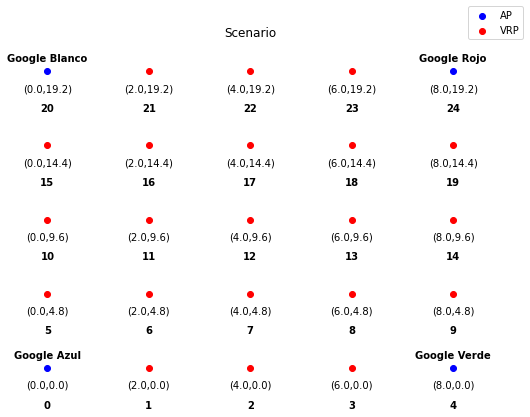

In [112]:
#@title ##Locations plot
plt.figure(figsize=(8,6))

plt.scatter(coordinates_ap[:,0], coordinates_ap[:,1], c='b')
plt.scatter(coordinates_vrp[:,0], coordinates_vrp[:,1], c='r')

plt.legend(labels=['AP','VRP'],loc="upper right",borderaxespad=-5)
plt.title('Scenario',pad=20)
plt.axis('off')

for x,y,z in zip(coordinates[:,0],coordinates[:,1], np.linspace(0, n_points - 1, n_points).astype(int)):
    label = f"({locations[z,0]},{locations[z,1]})"

    plt.annotate(label, # this is the text
                 (x,y), # this is the point to label
                 textcoords="offset points", # how to position the text
                 xytext=(0,-20), # distance from text to points (x,y)
                 ha='center') # horizontal alignment can be left, right or center

    label = f"{z}"

    plt.annotate(label, # this is the text
                  (x,y), # this is the point to label
                  textcoords="offset points", # how to position the text
                  xytext=(0,-40), # distance from text to points (x,y)
                  ha='center',
                  weight='bold') # horizontal alignment can be left, right or center

for x,y,z in zip(coordinates_ap[:,0],coordinates_ap[:,1], np.linspace(0, n_ap - 1, n_ap).astype(int)):
    label = f"{ap_labels[z]}"

    plt.annotate(label, # this is the text
                 (x,y), # this is the point to label
                 textcoords="offset points", # how to position the text
                 xytext=(0,10), # distance from text to points (x,y)
                 ha='center', # horizontal alignment can be left, right or center
                 weight='bold')

#RTT Observations among APs

In [113]:
"""
Compute Euclidean distance between APs
    
    array --> Array of AP/VRP locations
"""
def compute_euclidean_distance(array):
    n = array.shape[0]

    d_mat = [np.linalg.norm(i - j) for (i,j) in itertools.product(array, array)]
    d_mat = np.array(d_mat).reshape((n, n), order='F')

    return d_mat

In [114]:
"""
Target AP to compute algorithm: AP[0,0]

Let's assume an euclidean distance as RTT distance observations
""" 
d_RTT = compute_euclidean_distance(L_ap)

In [115]:
"""
Dataset split
    - ap_obs --> RTT observations between APs

We are getting RTT observations from dataset, splitting AP and VRP samples
"""
ap_obs = np.empty((n_ap, n_ap, 100))

df.sort_values(ap_mac)
for count, row in enumerate(L_ap):
  if row[0] == 8.0 and row[1] == 19.2:
    row[0] = 8.1
  aux = df.loc[(df['y'] == row[0]) & (df['x'] == row[1])]
  aux = aux[ap_mac].values
  aux = aux.T
  ap_obs[count,:,:] = aux

d_RTT = ap_obs[:,:,0].round(3)
print(d_RTT)

[[-1.118  8.076 17.094 18.667]
 [ 7.286 -0.57  17.233 16.989]
 [18.264 17.733 -0.361  8.573]
 [18.748 16.126  7.401 -1.829]]


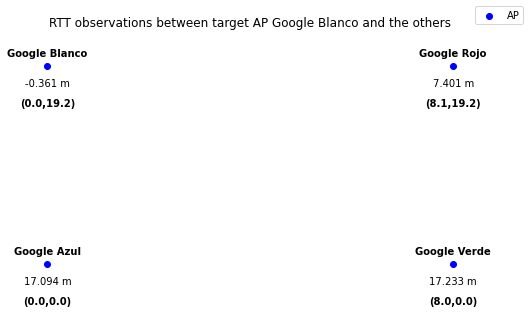

In [116]:
#@title ##Observations plot 
ap_selected = "Google Blanco"  #@param ['Google Blanco', 'Linksys 1', 'Google Azul', 'Linksys 2', 'Google Rojo', 'Linksys 3', 'Google Verde']

try:
  ap_indexes[ap_selected]
except:
  ap_selected = ap_labels[0]
  
plt.figure(figsize=(8,4))

plt.scatter(coordinates_ap[:,0], coordinates_ap[:,1], c='b')

plt.legend(labels=['AP'],loc="upper right",borderaxespad=-5)
plt.title('RTT observations between target AP '+ap_selected+' and the others',pad=30)
plt.axis('off')

for x,y,z in zip(coordinates_ap[:,0], coordinates_ap[:,1], d_RTT[:,int(ap_indexes[ap_selected])]):
    label = f"{z.round(3)} m"

    plt.annotate(label, # this is the text
                 (x,y), # this is the point to label
                 textcoords="offset points", # how to position the text
                 xytext=(0,-20), # distance from text to points (x,y)
                 ha='center') # horizontal alignment can be left, right or center

for x,y,z in zip(coordinates_ap[:,0],coordinates_ap[:,1], np.linspace(0, n_ap - 1, n_ap).astype(int)):

    label = f"{ap_labels[z]}"

    plt.annotate(label, # this is the text
                 (x,y), # this is the point to label
                 textcoords="offset points", # how to position the text
                 xytext=(0,10), # distance from text to points (x,y)
                 ha='center', # horizontal alignment can be left, right or center
                 weight='bold')

for x,y,z in zip(coordinates_ap[:,0],coordinates_ap[:,1], np.linspace(0, n_ap - 1, n_ap).astype(int)):
    label = f"({L_ap[z,0]},{L_ap[z,1]})"

    plt.annotate(label, # this is the text
                 (x,y), # this is the point to label
                 textcoords="offset points", # how to position the text
                 xytext=(0,-40), # distance from text to points (x,y)
                 ha='center',
                 weight='bold') # horizontal alignment can be left, right or center

#Polynomial Surface Fitting

In [117]:
"""
Polynomial Surface model fitting
    
    loc --> X,Y tuple array of AP locations
    d --> AP RTT distance observations
    order --> Polinomial order
"""
def surface_fit(loc, d, order=1):
    if order == 1:
        A = np.c_[loc[:,0], loc[:,1], np.ones(loc.shape[0])]
        C,_,_,_ = scipy.linalg.lstsq(A, d)
    else:
        A = np.c_[np.ones(loc.shape[0]), loc[:,:2], np.prod(loc[:,:2], axis=1), loc[:,:2]**2]
        C,_,_,_ = scipy.linalg.lstsq(A, d)
    return C

In [118]:
"""
RTT distance estimation
    
    x --> AP's x locations
    y --> AP's y locations
    C --> Model coefficients
"""
def sample_distance(x, y, C):
    XX = x.flatten()
    YY = y.flatten()
    
    if C.shape[0] == 3:
        fit = np.dot(np.c_[XX, YY, np.ones(XX.shape)], C).reshape(x.shape)
    else:
        fit = np.dot(np.c_[np.ones(XX.shape), XX, YY, XX*YY, XX**2, YY**2], C).reshape(x.shape)
    return fit

In [119]:
"""
Surface fitting models
"""

"""
Plot domain
"""
X,Y = np.meshgrid(np.linspace(0, width, points_x).round(3), np.linspace(0, height, points_y).round(3))

"""
Models fitting and surface estimation
"""
models_1 = np.array([surface_fit(L_ap, d_RTT[:,i]) for (i) in np.linspace(0, n_ap - 1, n_ap).astype(int)])
models_2 = np.array([surface_fit(L_ap, d_RTT[:,i],2) for (i) in np.linspace(0, n_ap - 1, n_ap).astype(int)])

Z_1 = np.array([sample_distance(X, Y, models_1[i]) for (i) in np.linspace(0, n_ap - 1, n_ap).astype(int)])
Z_2 = np.array([sample_distance(X, Y, models_2[i]) for (i) in np.linspace(0, n_ap - 1, n_ap).astype(int)])

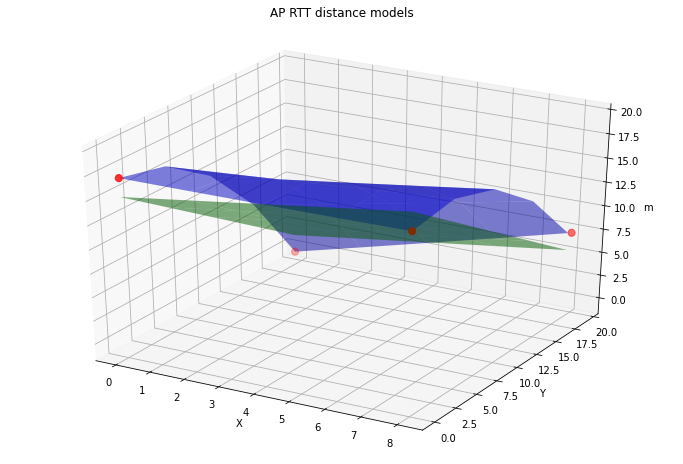

In [120]:
#@title ##Surface Fitting Models Plot
ap_selected = "Google Blanco"  #@param ['Google Blanco', 'Linksys 1', 'Google Azul', 'Linksys 2', 'Google Rojo', 'Linksys 3', 'Google Verde']

try:
  ap_indexes[ap_selected]
except:
  ap_selected = ap_labels[0]

fig = plt.figure(figsize=(12,8))

ax = fig.gca(projection='3d')

l1 = ax.plot_surface(X, Y, Z_1[int(ap_indexes[ap_selected]),:,:], rstride=1, cstride=1, alpha=0.5, label='linear', color='g')
l2 = ax.plot_surface(X, Y, Z_2[int(ap_indexes[ap_selected]),:,:], rstride=1, cstride=1, alpha=0.5, label='quadratic', color='b')

ax.scatter(L_ap[:,0], L_ap[:,1], d_RTT[:,int(ap_indexes[ap_selected])], c='r', s=50)

plt.xlabel('X')
plt.ylabel('Y')
ax.set_zlabel('m')
ax.axis('auto')

line_labels = ["AP locations","Linear", "Quadratic"]

#ax.plot([0], [0], d_RTT[:,int(ap_indexes[ap_selected])][0], color="red", marker='o', linewidth=0)[0]
#ax.plot([0], [0], color="green")[0]
#ax.plot([0], [0], color="blue")[0]

#fig.legend(labels=line_labels,loc="upper right",borderaxespad=4)

plt.title('AP RTT distance models', pad=40)
plt.show()

##Mean RTT Distance vectors

In [121]:
"""
Mean RTT distance values at VRPs
    _1 --> Order 1 surface fit
    _2 --> Order 2 surface fit
"""

fit_1 = np.reshape(Z_1, (n_ap, n_points, 1))
fit_2 = np.reshape(Z_2, (n_ap, n_points, 1))

"""
  Mean RTT observations between target AP and the rest
"""
m_ap_1 = fit_1[:,points,:]
m_ap_2 = fit_2[:,points, :]
vrp_pts = np.delete(np.linspace(0, n_points - 1, n_points).astype(int), points, 0)

"""
Mean RTT observations between target AP and VRPs
"""
m_vrp_1 = fit_1[:,vrp_pts,:]
m_vrp_2 = fit_2[:,vrp_pts,:]

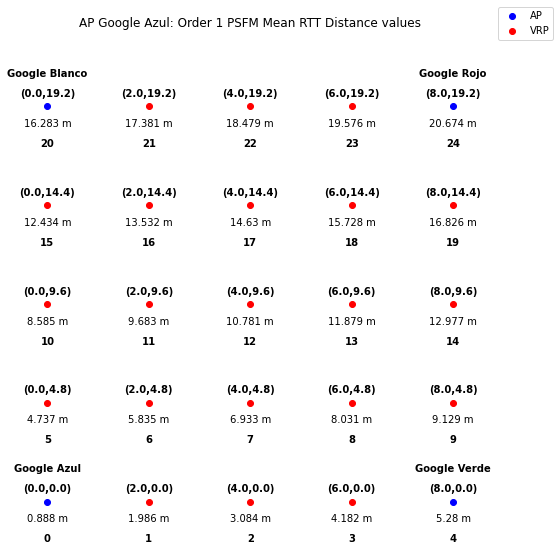

In [122]:
#@title ##Order 1 PSFM Mean RTT Distance Plot
ap_selected = "Google Azul"  #@param ['Google Blanco', 'Linksys 1', 'Google Azul', 'Linksys 2', 'Google Rojo', 'Linksys 3', 'Google Verde']

try:
  ap_indexes[ap_selected]
except:
  ap_selected = ap_labels[0]

plt.figure(figsize=(8,8))

plt.scatter(coordinates_ap[:,0], coordinates_ap[:,1], c='b')
plt.scatter(coordinates_vrp[:,0], coordinates_vrp[:,1], c='r')

plt.legend(labels=['AP','VRP'],loc="upper right",borderaxespad=-8)
plt.title('AP '+ap_selected+': Order 1 PSFM Mean RTT Distance values',pad=60)
plt.axis('off')

for x,y,z in zip(coordinates[:,0], coordinates[:,1], np.linspace(0, n_points - 1, n_points).astype(int)):
    label = f"{sample_distance(locations[z,0], locations[z,1], models_1[int(ap_indexes[ap_selected])]).round(3)} m"

    plt.annotate(label, # this is the text
                 (x,y), # this is the point to label
                 textcoords="offset points", # how to position the text
                 xytext=(0,-20), # distance from text to points (x,y)
                 ha='center') # horizontal alignment can be left, right or center

for x,y,z in zip(coordinates[:,0],coordinates[:,1], np.linspace(0, n_points - 1, n_points).astype(int)):
    label = f"({locations[z,0]},{locations[z,1]})"

    plt.annotate(label, # this is the text
                 (x,y), # this is the point to label
                 textcoords="offset points", # how to position the text
                 xytext=(0,10), # distance from text to points (x,y)
                 ha='center',
                 weight='bold') # horizontal alignment can be left, right or center

    label = f"{z}"

    plt.annotate(label, # this is the text
                  (x,y), # this is the point to label
                  textcoords="offset points", # how to position the text
                  xytext=(0,-40), # distance from text to points (x,y)
                  ha='center',
                  weight='bold') # horizontal alignment can be left, right or center

for x,y,z in zip(coordinates_ap[:,0],coordinates_ap[:,1], np.linspace(0, n_ap - 1, n_ap).astype(int)):

    label = f"{ap_labels[z]}"

    plt.annotate(label, # this is the text
                 (x,y), # this is the point to label
                 textcoords="offset points", # how to position the text
                 xytext=(0,30), # distance from text to points (x,y)
                 ha='center', # horizontal alignment can be left, right or center
                 weight='bold')

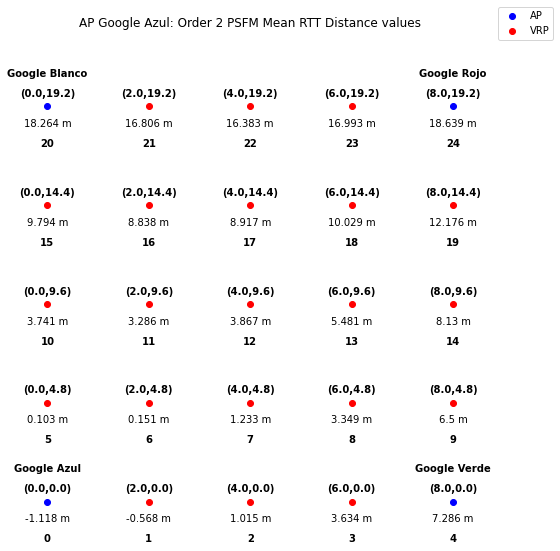

In [123]:
#@title ##Order 2 PSFM Mean RTT Distance Plot
ap_selected = "Google Azul"  #@param ['Google Blanco', 'Linksys 1', 'Google Azul', 'Linksys 2', 'Google Rojo', 'Linksys 3', 'Google Verde']

try:
  ap_indexes[ap_selected]
except:
  ap_selected = ap_labels[0]

plt.figure(figsize=(8,8))

plt.scatter(coordinates_ap[:,0], coordinates_ap[:,1], c='b')
plt.scatter(coordinates_vrp[:,0], coordinates_vrp[:,1], c='r')

plt.legend(labels=['AP','VRP'],loc="upper right",borderaxespad=-8)
plt.title('AP '+ap_selected+': Order 2 PSFM Mean RTT Distance values',pad=60)
plt.axis('off')

for x,y,z in zip(coordinates[:,0], coordinates[:,1], np.linspace(0, n_points - 1, n_points).astype(int)):
    label = f"{sample_distance(locations[z,0], locations[z,1], models_2[int(ap_indexes[ap_selected])]).round(3)} m"

    plt.annotate(label, # this is the text
                 (x,y), # this is the point to label
                 textcoords="offset points", # how to position the text
                 xytext=(0,-20), # distance from text to points (x,y)
                 ha='center') # horizontal alignment can be left, right or center

for x,y,z in zip(coordinates[:,0],coordinates[:,1], np.linspace(0, n_points - 1, n_points).astype(int)):
    label = f"({locations[z,0]},{locations[z,1]})"

    plt.annotate(label, # this is the text
                 (x,y), # this is the point to label
                 textcoords="offset points", # how to position the text
                 xytext=(0,10), # distance from text to points (x,y)
                 ha='center',
                 weight='bold') # horizontal alignment can be left, right or center

    label = f"{z}"

    plt.annotate(label, # this is the text
                  (x,y), # this is the point to label
                  textcoords="offset points", # how to position the text
                  xytext=(0,-40), # distance from text to points (x,y)
                  ha='center',
                  weight='bold') # horizontal alignment can be left, right or center

for x,y,z in zip(coordinates_ap[:,0],coordinates_ap[:,1], np.linspace(0, n_ap - 1, n_ap).astype(int)):

    label = f"{ap_labels[z]}"

    plt.annotate(label, # this is the text
                 (x,y), # this is the point to label
                 textcoords="offset points", # how to position the text
                 xytext=(0,30), # distance from text to points (x,y)
                 ha='center', # horizontal alignment can be left, right or center
                 weight='bold')

#Gaussian Process Regression

##Kernel definition

In [124]:
"""
Gaussian Process Kernel definition

Kernel parameters:
    - L --> Length Scale
    - sigma_f --> Constant Kernel Amplitude
"""

def kernel_function(x, y, sigma_f=1, l=1):

    """ Squared Exponential kernel function """
    kernel = sigma_f * np.exp(- (np.linalg.norm(x - y)**2) / (2 * l**2))
    return kernel

##Hyperparameter optimization

In [125]:
"""
Hyperparameter optimization of sigma_f and length-scale

    loc --> AP locations
    mean --> RTT distance observations between APs
"""
def gp_fit(loc, mean):
    
    gp.fit(loc, mean)

    l = gp.kernel_.get_params().get('k2__length_scale')
    sigma_f = gp.kernel_.get_params().get('k1__constant_value')
    return l, sigma_f

In [126]:
"""
Gaussian Process Fit using scikit-learn GPR
"""
sigma_n = 0.0

kernel = ConstantKernel(constant_value=100.0,constant_value_bounds=(1e-3, 1e3)) \
            * RBF(length_scale=10.0, length_scale_bounds=(1e-3, 1e3))

gp = GaussianProcessRegressor(kernel=kernel, alpha=sigma_n**2, n_restarts_optimizer=0)

hyper_params = np.array([gp_fit(L_ap, d_RTT[:,i]) for (i) in np.linspace(0, n_ap - 1, n_ap).astype(int)])

##GPR Class definition

### Handles the required parameters for each GPR interpolation

####Parameters:

*   **K (ndarray):** Covariance matrix between AP locations
*   **K_star2 (ndarray):** Covariance matrix between VRP locations
*   **K_star (ndarray):** Covariance matrix between each AP location and each VRP location
*   **m_ap (ndarray):** Mean RTT distance values at AP locations from fitting model
*   **m_vrp (ndarray):** Mean RTT distance values at VRP locations from fitting model

In [127]:
class Regressor:
    def __init__(self, _K, _K_star2, _K_star, _m_ap, _m_vrp, _m_ap2, _m_vrp2):
        self.K = _K
        self.K_star2 = _K_star2
        self.K_star = _K_star
        self.m_ap = _m_ap
        self.m_vrp = _m_vrp
        self.m_ap2 = _m_ap2
        self.m_vrp2 = _m_vrp2

##GPR Structure Computing

###Compute components of the covariance matrix of the joint distribution
Covariance Matrices Notation:

* K = K(L_ap, L_ap) 
* K_star = K(L_vrp, L_ap)
* K_star2 = K(L_vrp, L_vrp)

In [128]:
def compute_cov_matrices(L_ap, L_vrp, sigma_f=1, l=1):
    """
    Compute components of the covariance matrix of the joint distribution.
    
    We follow the notation:
    
        - K = K(L, L) 
        - K_star = K(L^*, L)
        - K_star2 = K(L^*, L^*)
    """
    n = L_ap.shape[0]
    n_star = L_vrp.shape[0]

    K = [kernel_function(i, j, sigma_f=sigma_f, l=l) for (i, j) in itertools.product(L_ap, L_ap)]

    K = np.array(K).reshape(n, n)
    
    K_star2 = [kernel_function(i, j, sigma_f=sigma_f, l=l) for (i, j) in itertools.product(L_vrp, L_vrp)]

    K_star2 = np.array(K_star2).reshape(n_star, n_star)
    
    K_star = [kernel_function(i, j, sigma_f=sigma_f, l=l) for (i, j) in itertools.product(L_vrp, L_ap)]

    K_star = np.array(K_star).reshape(n_star, n)
    
    return (K, K_star2, K_star)

##Covariance matrices and regressor objects computing:

- Covariance matrices: K, K_star, K_star2
- Mean distance values: m_ap, m_vrp

 

In [129]:
"""
Covariance matrices and regressor objects computing:

    - Covariance matrices: K, K_star, K_star2
    - Mean distance values: m_ap, m_vrp 
"""

list = []

for i in np.linspace(0, n_ap - 1, n_ap).astype(int):
    a, b, c = compute_cov_matrices(L_ap, L_vrp, sigma_f=hyper_params[i][1], l=hyper_params[i][0])
    gpr = Regressor(a,b,c,m_ap_1[i],m_vrp_1[i],m_ap_2[i],m_vrp_2[i])
    list.append(gpr)

In [130]:
#@title ##Multivariate Gaussian Process Dimension Check
ap_selected = "Linksys 1"  #@param ['Google Blanco', 'Linksys 1', 'Google Azul', 'Linksys 2', 'Google Rojo', 'Linksys 3', 'Google Verde']

try:
  ap_indexes[ap_selected]
except:
  ap_selected = ap_labels[0]
  
"""
Multivariate Joint Distribution Check: G matrix
"""

n = L_ap.shape[0]
n_star = L_vrp.shape[0]

a = np.concatenate((list[int(ap_indexes[ap_selected])].K + (sigma_n**2)*np.eye(n), list[int(ap_indexes[ap_selected])].K_star), axis=0)
print(a.shape)
b = np.concatenate((list[int(ap_indexes[ap_selected])].K_star.T, list[int(ap_indexes[ap_selected])].K_star2), axis=0)
print(b.shape)
G = np.concatenate((a, b), axis=1)
print(G.shape)
G.shape == (n + n_star, n + n_star)

(25, 4)
(25, 21)
(25, 25)


True


Covariance matrices: 




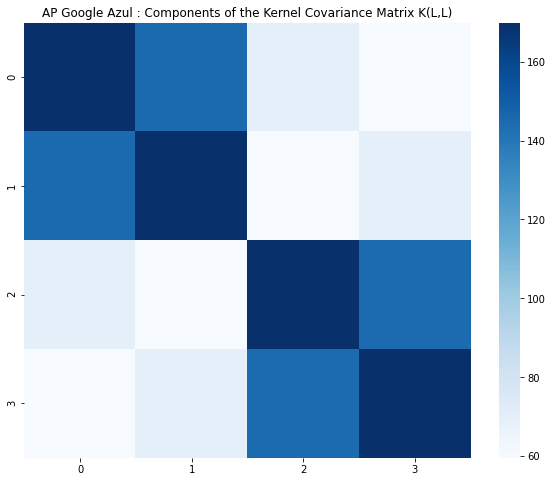

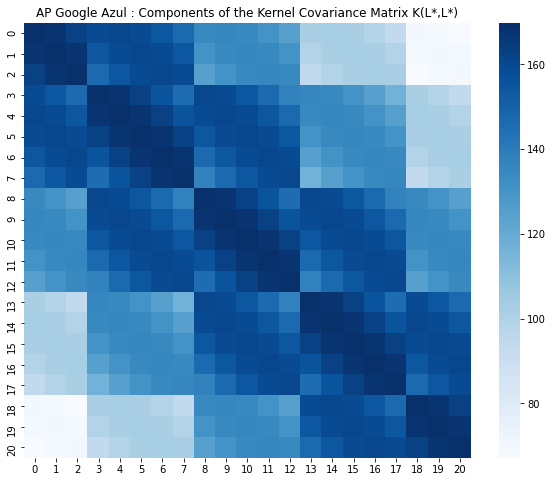

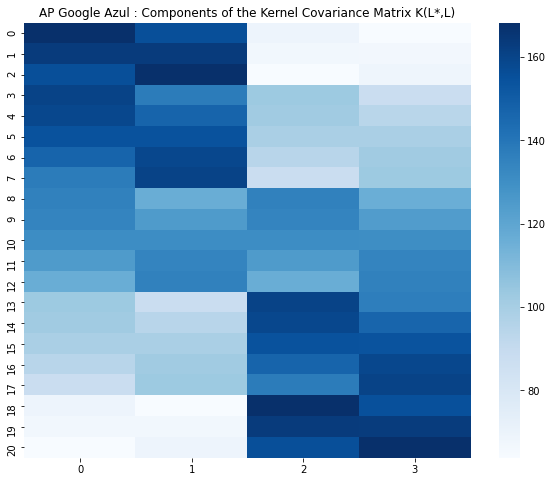

In [131]:
#@title ##Covariance Matrices Plot
ap_selected = "Linksys 1"  #@param ['Google Blanco', 'Linksys 1', 'Google Azul', 'Linksys 2', 'Google Rojo', 'Linksys 3', 'Google Verde']

try:
  ap_indexes[ap_selected]
except:
  ap_selected = ap_labels[0]
  
"""
Kernel Covariance Matrix K(L,L)
"""
fig, ax = plt.subplots(figsize=(10, 8))
sns.heatmap(data=list[int(ap_indexes[ap_selected])].K, cmap='Blues', ax=ax)
ax.set(title='AP '+ap_selected+' : Components of the Kernel Covariance Matrix K(L,L)')

"""
Kernel Covariance Matrix K(L*,L*)
"""
fig, ax = plt.subplots(figsize=(10, 8))
sns.heatmap(data=list[int(ap_indexes[ap_selected])].K_star2, cmap='Blues', ax=ax)
ax.set(title='AP '+ap_selected+' : Components of the Kernel Covariance Matrix K(L*,L*)')

"""
Kernel Covariance Matrix K(L*,L)
"""
fig, ax = plt.subplots(figsize=(10, 8))
sns.heatmap(data=list[int(ap_indexes[ap_selected])].K_star, cmap='Blues', ax=ax)
ax.set(title='AP '+ap_selected+' : Components of the Kernel Covariance Matrix K(L*,L)')
print("\nCovariance matrices: \n\n")

#PSFM GPR Interpolation

##Interpolation Computing

In [132]:
def psfm_gpr_parameters(m, m_star, d, K, K_star2, K_star, sigma_n):
    
    """Compute gaussian regression parameters."""

    n = K.shape[0]
    n_star = K_star.shape[0]
    
    # Mean.
    s_bar_star = (m_star.reshape([n_star, 1]) 
        + np.dot(K_star, np.dot(np.linalg.inv(K + (sigma_n**2)*np.eye(n)), d.reshape([n, 1]) - m.reshape([n, 1]))))
    # Covariance.
    cov_s_star = K_star2 - np.dot(K_star, np.dot(np.linalg.inv(K + (sigma_n**2)*np.eye(n)), K_star.T))
    
    return (s_bar_star.reshape(n_star), cov_s_star)

In [133]:
def zero_mean_gpr_parameters(d, K, K_star2, K_star, sigma_n):
    
    """Compute gaussian regression parameters."""

    n = K.shape[0]
    n_star = K_star.shape[0]

    # Mean.
    s_bar_star = np.dot(K_star, np.dot(np.linalg.inv(K + (sigma_n**2)*np.eye(n)), d.reshape([n, 1])))
    # Covariance.
    cov_s_star = K_star2 - np.dot(K_star, np.dot(np.linalg.inv(K + (sigma_n**2)*np.eye(n)), K_star.T))
    
    return (s_bar_star.reshape(n_star), cov_s_star)

In [134]:
"""
Zero-Mean Gaussian Process interpolations
"""
n = L_ap.shape[0]
n_star = L_vrp.shape[0]

means = np.empty((n, n_star, 1))
variances = np.empty((n, n_star, 1))

for i in np.linspace(0, n_ap - 1, n_ap).astype(int):

    s_bar_star, cov_s_star = zero_mean_gpr_parameters(d_RTT[:,i], list[i].K, list[i].K_star2, list[i].K_star, sigma_n)
    var_s_star = np.diag(cov_s_star)

    means[i,:,:] = s_bar_star.reshape(n_star,1)
    variances[i,:,:] = var_s_star.reshape(n_star,1)

In [135]:
"""
Order 1 PSFM Gaussian Process interpolations
"""
means_psfm = np.empty((n, n_star, 1))

for i in np.linspace(0, n_ap - 1, n_ap).astype(int):
  
    s_bar_star, cov_s_star = psfm_gpr_parameters(list[i].m_ap,list[i].m_vrp, d_RTT[:,i], list[i].K, list[i].K_star2, list[i].K_star, sigma_n)
    means_psfm[i,:,:] = s_bar_star.reshape(n_star,1)

In [136]:
"""
Order 2 PSFM Gaussian Process interpolations
"""
means_psfm2 = np.empty((n, n_star, 1))

for i in np.linspace(0, n_ap - 1, n_ap).astype(int):
  
    s_bar_star, cov_s_star = psfm_gpr_parameters(list[i].m_ap2,list[i].m_vrp2, d_RTT[:,i], list[i].K, list[i].K_star2, list[i].K_star, sigma_n)
    means_psfm2[i,:,:] = s_bar_star.reshape(n_star,1)

##Interpolation Plots

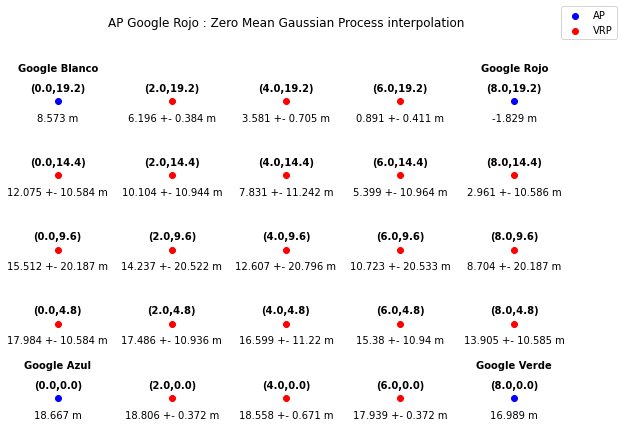

In [142]:
#@title ##Zero-Mean GPR
ap_selected = "Google Rojo"  #@param ['Google Blanco', 'Linksys 1', 'Google Azul', 'Linksys 2', 'Google Rojo', 'Linksys 3', 'Google Verde']

try:
  ap_indexes[ap_selected]
except:
  ap_selected = ap_labels[0]
  
"""
Zero Mean Gaussian Process interpolation:
    
    s_bar_star --> Mean estimated value for each VRP
    cov_s_star --> Posterior covariance matrix
    var_s_star --> VRP estimation variance
"""

plt.figure(figsize=(9,6))

plt.scatter(coordinates_ap[:,0], coordinates_ap[:,1], c='b')
plt.scatter(coordinates_vrp[:,0], coordinates_vrp[:,1], c='r')

plt.legend(labels=['AP','VRP'],loc="upper right",borderaxespad=-8)
plt.title('AP '+ap_selected+' : Zero Mean Gaussian Process interpolation',pad=60)
plt.axis('off')

for x,y,z in zip(coordinates_ap[:,0], coordinates_ap[:,1], d_RTT[:,int(ap_indexes[ap_selected])]):
    label = f"{z.round(3)} m"

    plt.annotate(label, # this is the text
                 (x,y), # this is the point to label
                 textcoords="offset points", # how to position the text
                 xytext=(0,-20), # distance from text to points (x,y)
                 ha='center') # horizontal alignment can be left, right or center

for x in range(len(means[int(ap_indexes[ap_selected])])):
    label = f"{means[int(ap_indexes[ap_selected])][x,0].round(3)} +- {variances[int(ap_indexes[ap_selected])][x,0].round(3)} m"

    plt.annotate(label, # this is the text
                 (coordinates_vrp[x,0],coordinates_vrp[x,1]), # this is the point to label
                 textcoords="offset points", # how to position the text
                 xytext=(0,-20), # distance from text to points (x,y)
                 ha='center') # horizontal alignment can be left, right or center

for x,y,z in zip(coordinates_ap[:,0],coordinates_ap[:,1], np.linspace(0, n_ap - 1, n_ap).astype(int)):

    label = f"{ap_labels[z]}"

    plt.annotate(label, # this is the text
                 (x,y), # this is the point to label
                 textcoords="offset points", # how to position the text
                 xytext=(0,30), # distance from text to points (x,y)
                 ha='center', # horizontal alignment can be left, right or center
                 weight='bold')

for x,y,z in zip(coordinates[:,0],coordinates[:,1], np.linspace(0, n_points - 1, n_points).astype(int)):
    label = f"({locations[z,0]},{locations[z,1]})"

    plt.annotate(label, # this is the text
                 (x,y), # this is the point to label
                 textcoords="offset points", # how to position the text
                 xytext=(0,10), # distance from text to points (x,y)
                 ha='center',
                 weight='bold') # horizontal alignment can be left, right or center

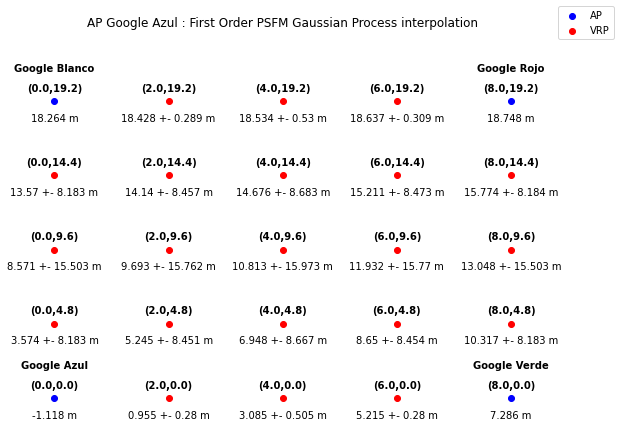

In [138]:
#@title ##First Order PSFM GPR
ap_selected = "Google Azul"  #@param ['Google Blanco', 'Linksys 1', 'Google Azul', 'Linksys 2', 'Google Rojo', 'Linksys 3', 'Google Verde']

try:
  ap_indexes[ap_selected]
except:
  ap_selected = ap_labels[0]

"""
First Order PSFM Gaussian Process interpolation:
    
    s_bar_star --> Mean estimated value for each VRP
    cov_s_star --> Posterior covariance matrix
    var_s_star --> VRP estimation variance
"""

plt.figure(figsize=(9,6))

plt.scatter(coordinates_ap[:,0], coordinates_ap[:,1], c='b')
plt.scatter(coordinates_vrp[:,0], coordinates_vrp[:,1], c='r')

plt.legend(labels=['AP','VRP'],loc="upper right",borderaxespad=-8)
plt.title('AP '+ap_selected+' : First Order PSFM Gaussian Process interpolation',pad=60)
plt.axis('off')

for x,y,z in zip(coordinates_ap[:,0], coordinates_ap[:,1], d_RTT[:,int(ap_indexes[ap_selected])]):
    label = f"{z.round(3)} m"

    plt.annotate(label, # this is the text
                 (x,y), # this is the point to label
                 textcoords="offset points", # how to position the text
                 xytext=(0,-20), # distance from text to points (x,y)
                 ha='center') # horizontal alignment can be left, right or center

for x in range(len(means_psfm[int(ap_indexes[ap_selected])])):
    label = f"{means_psfm[int(ap_indexes[ap_selected])][x,0].round(3)} +- {variances[int(ap_indexes[ap_selected])][x,0].round(3)} m"

    plt.annotate(label, # this is the text
                 (coordinates_vrp[x,0],coordinates_vrp[x,1]), # this is the point to label
                 textcoords="offset points", # how to position the text
                 xytext=(0,-20), # distance from text to points (x,y)
                 ha='center') # horizontal alignment can be left, right or center

for x,y,z in zip(coordinates_ap[:,0],coordinates_ap[:,1], np.linspace(0, n_ap - 1, n_ap).astype(int)):

    label = f"{ap_labels[z]}"

    plt.annotate(label, # this is the text
                 (x,y), # this is the point to label
                 textcoords="offset points", # how to position the text
                 xytext=(0,30), # distance from text to points (x,y)
                 ha='center', # horizontal alignment can be left, right or center
                 weight='bold')

for x,y,z in zip(coordinates[:,0],coordinates[:,1], np.linspace(0, n_points - 1, n_points).astype(int)):
    label = f"({locations[z,0]},{locations[z,1]})"

    plt.annotate(label, # this is the text
                 (x,y), # this is the point to label
                 textcoords="offset points", # how to position the text
                 xytext=(0,10), # distance from text to points (x,y)
                 ha='center',
                 weight='bold') # horizontal alignment can be left, right or center

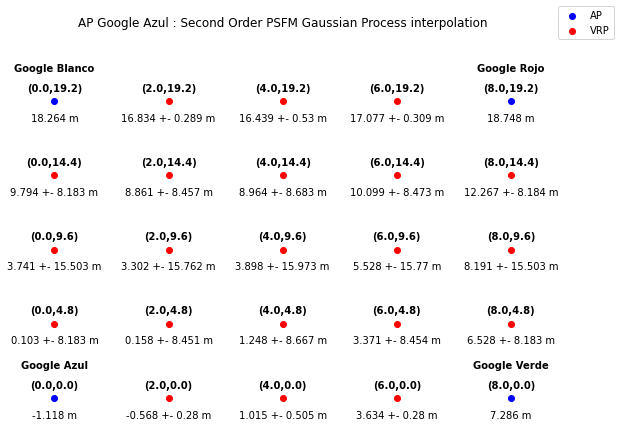

In [139]:
#@title ##Second Order PSFM GPR
ap_selected = "Google Azul"  #@param ['Google Blanco', 'Linksys 1', 'Google Azul', 'Linksys 2', 'Google Rojo', 'Linksys 3', 'Google Verde']

try:
  ap_indexes[ap_selected]
except:
  ap_selected = ap_labels[0]

"""
Second Order PSFM Gaussian Process interpolation:
    
    s_bar_star --> Mean estimated value for each VRP
    cov_s_star --> Posterior covariance matrix
    var_s_star --> VRP estimation variance
"""

plt.figure(figsize=(9,6))

plt.scatter(coordinates_ap[:,0], coordinates_ap[:,1], c='b')
plt.scatter(coordinates_vrp[:,0], coordinates_vrp[:,1], c='r')

plt.legend(labels=['AP','VRP'],loc="upper right",borderaxespad=-8)
plt.title('AP '+ap_selected+' : Second Order PSFM Gaussian Process interpolation',pad=60)
plt.axis('off')

for x,y,z in zip(coordinates_ap[:,0], coordinates_ap[:,1], d_RTT[:,int(ap_indexes[ap_selected])]):
    label = f"{z.round(3)} m"

    plt.annotate(label, # this is the text
                 (x,y), # this is the point to label
                 textcoords="offset points", # how to position the text
                 xytext=(0,-20), # distance from text to points (x,y)
                 ha='center') # horizontal alignment can be left, right or center

for x in range(len(means_psfm2[int(ap_indexes[ap_selected])])):
    label = f"{means_psfm2[int(ap_indexes[ap_selected])][x,0].round(3)} +- {variances[int(ap_indexes[ap_selected])][x,0].round(3)} m"

    plt.annotate(label, # this is the text
                 (coordinates_vrp[x,0],coordinates_vrp[x,1]), # this is the point to label
                 textcoords="offset points", # how to position the text
                 xytext=(0,-20), # distance from text to points (x,y)
                 ha='center') # horizontal alignment can be left, right or center

for x,y,z in zip(coordinates_ap[:,0],coordinates_ap[:,1], np.linspace(0, n_ap - 1, n_ap).astype(int)):

    label = f"{ap_labels[z]}"

    plt.annotate(label, # this is the text
                 (x,y), # this is the point to label
                 textcoords="offset points", # how to position the text
                 xytext=(0,30), # distance from text to points (x,y)
                 ha='center', # horizontal alignment can be left, right or center
                 weight='bold')

for x,y,z in zip(coordinates[:,0],coordinates[:,1], np.linspace(0, n_points - 1, n_points).astype(int)):
    label = f"({locations[z,0]},{locations[z,1]})"

    plt.annotate(label, # this is the text
                 (x,y), # this is the point to label
                 textcoords="offset points", # how to position the text
                 xytext=(0,10), # distance from text to points (x,y)
                 ha='center',
                 weight='bold') # horizontal alignment can be left, right or center

#Fingerprinting Database Construction

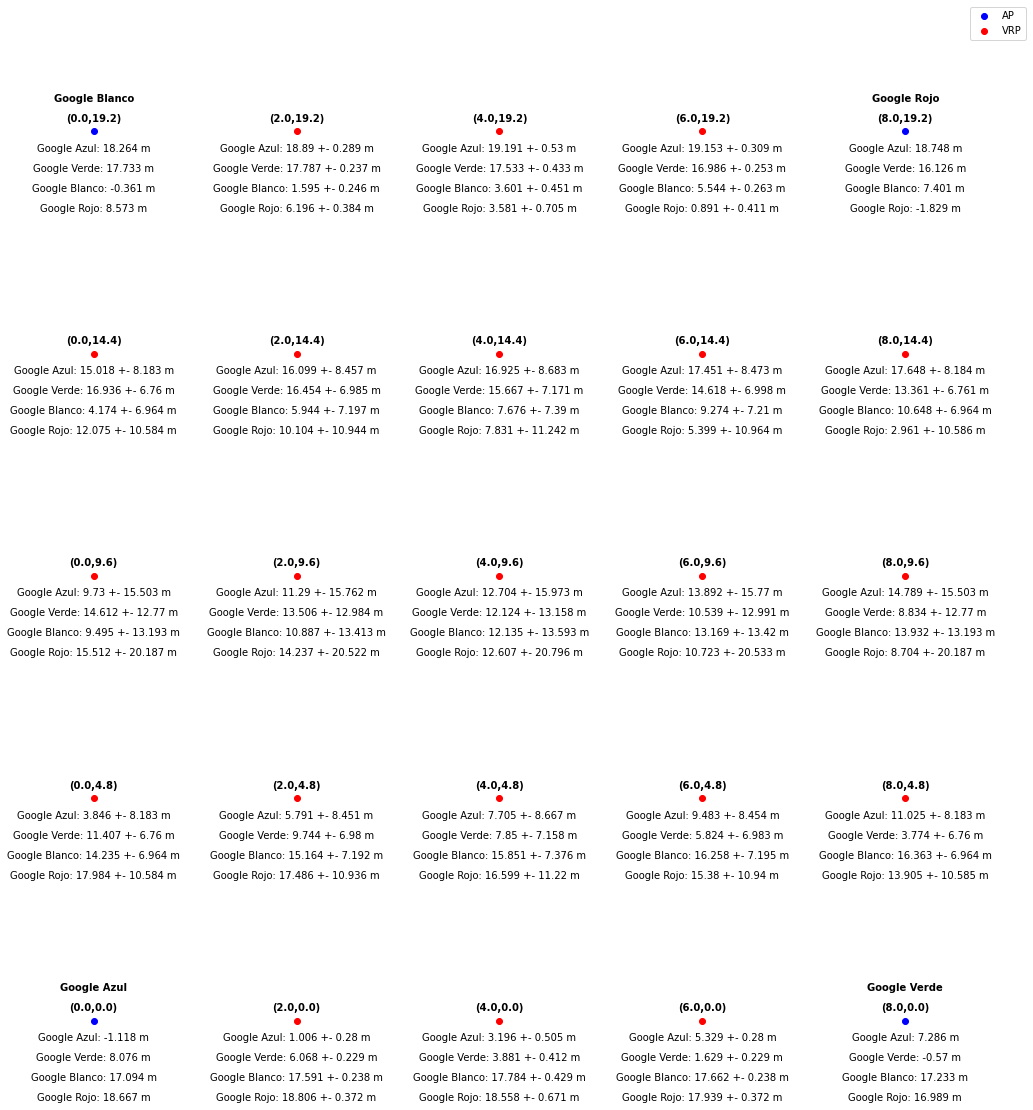

In [143]:
#@title ##Zero Mean GPR Fingerprinting Database plot

plt.figure(figsize=(16,18))

plt.scatter(coordinates_ap[:,0], coordinates_ap[:,1], c='b')
plt.scatter(coordinates_vrp[:,0], coordinates_vrp[:,1], c='r')

plt.legend(labels=['AP','VRP'],loc="upper right",borderaxespad=-8)
plt.axis('off')

for x in range(len(d_RTT[:,0])):
    for y in range(len(d_RTT[:,0])):
        label = f"{ap_labels[y]}: {d_RTT[x,y].round(3)} m"

        plt.annotate(label, # this is the text
                    (coordinates_ap[x,0],coordinates_ap[x,1]), # this is the point to label
                    textcoords="offset points", # how to position the text
                    xytext=(0,-20-y*20), # distance from text to points (x,y)
                    ha='center') # horizontal alignment can be left, right or center

for x in range(len(means[0])):
    for y in range(len(d_RTT[:,0])):
        label = f"{ap_labels[y]}: {means[:,x,:][y,0].round(3)} +- {variances[:,x,:][y,0].round(3)} m"

        plt.annotate(label, # this is the text
                    (coordinates_vrp[x,0],coordinates_vrp[x,1]), # this is the point to label
                    textcoords="offset points", # how to position the text
                    xytext=(0,-20-y*20), # distance from text to points (x,y)
                    ha='center') # horizontal alignment can be left, right or center


for x,y,z in zip(coordinates_ap[:,0],coordinates_ap[:,1], np.linspace(0, n_ap - 1, n_ap).astype(int)):

    label = f"{ap_labels[z]}"

    plt.annotate(label, # this is the text
                 (x,y), # this is the point to label
                 textcoords="offset points", # how to position the text
                 xytext=(0,30), # distance from text to points (x,y)
                 ha='center', # horizontal alignment can be left, right or center
                 weight='bold')


for x,y,z in zip(coordinates[:,0],coordinates[:,1], np.linspace(0, n_points - 1, n_points).astype(int)):
    label = f"({locations[z,0]},{locations[z,1]})"

    plt.annotate(label, # this is the text
                 (x,y), # this is the point to label
                 textcoords="offset points", # how to position the text
                 xytext=(0,10), # distance from text to points (x,y)
                 ha='center',
                 weight='bold') # horizontal alignment can be left, right or center

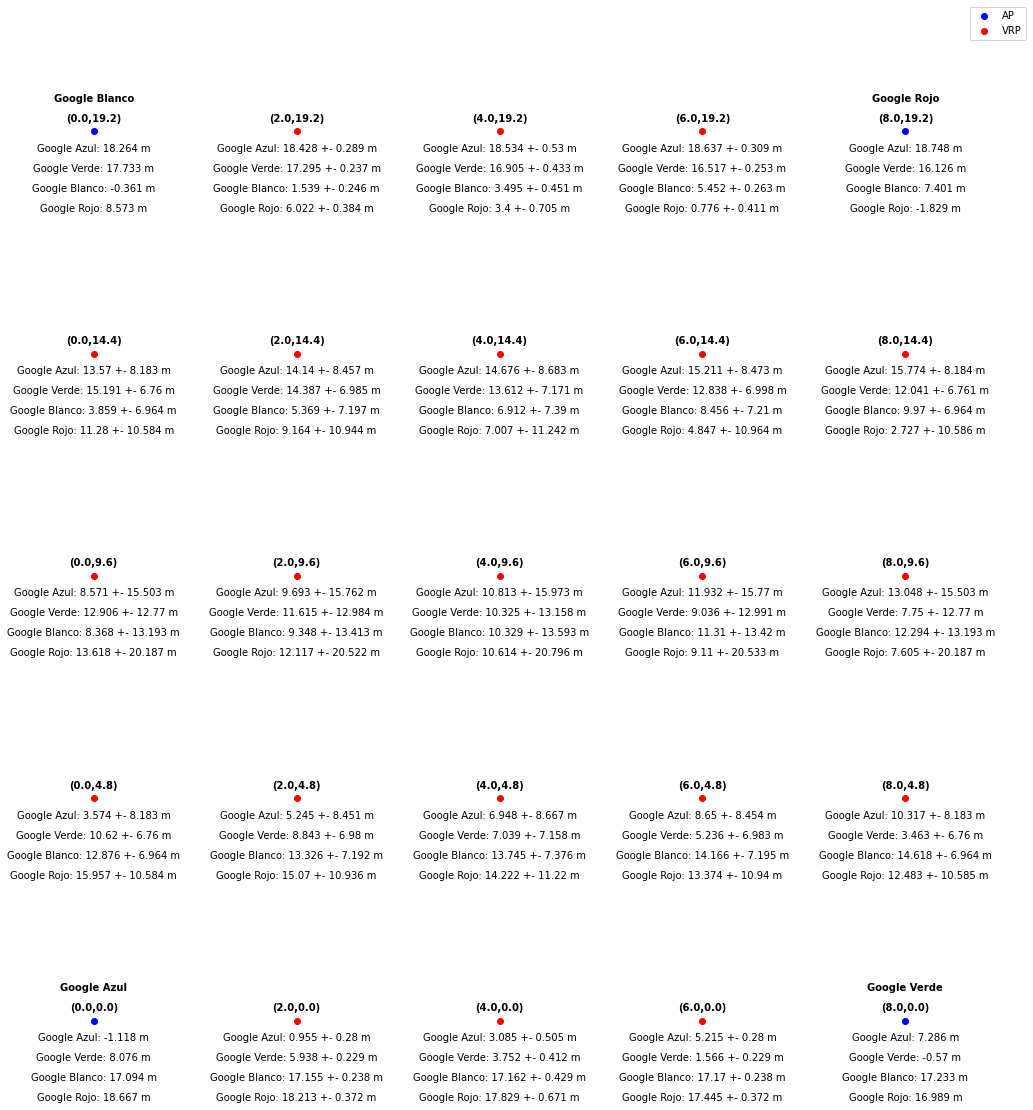

In [144]:
#@title ##First Order PSFM GPR Fingerprinting Database plot

plt.figure(figsize=(16,18))

plt.scatter(coordinates_ap[:,0], coordinates_ap[:,1], c='b')
plt.scatter(coordinates_vrp[:,0], coordinates_vrp[:,1], c='r')

plt.legend(labels=['AP','VRP'],loc="upper right",borderaxespad=-8)
plt.axis('off')

for x in range(len(d_RTT[:,0])):
    for y in range(len(d_RTT[:,0])):
        label = f"{ap_labels[y]}: {d_RTT[x,y].round(3)} m"

        plt.annotate(label, # this is the text
                    (coordinates_ap[x,0],coordinates_ap[x,1]), # this is the point to label
                    textcoords="offset points", # how to position the text
                    xytext=(0,-20-y*20), # distance from text to points (x,y)
                    ha='center') # horizontal alignment can be left, right or center

for x in range(len(means_psfm[0])):
    for y in range(len(d_RTT[:,0])):
        label = f"{ap_labels[y]}: {means_psfm[:,x,:][y,0].round(3)} +- {variances[:,x,:][y,0].round(3)} m"

        plt.annotate(label, # this is the text
                    (coordinates_vrp[x,0],coordinates_vrp[x,1]), # this is the point to label
                    textcoords="offset points", # how to position the text
                    xytext=(0,-20-y*20), # distance from text to points (x,y)
                    ha='center') # horizontal alignment can be left, right or center

for x,y,z in zip(coordinates_ap[:,0],coordinates_ap[:,1], np.linspace(0, n_ap - 1, n_ap).astype(int)):

    label = f"{ap_labels[z]}"

    plt.annotate(label, # this is the text
                 (x,y), # this is the point to label
                 textcoords="offset points", # how to position the text
                 xytext=(0,30), # distance from text to points (x,y)
                 ha='center', # horizontal alignment can be left, right or center
                 weight='bold')

for x,y,z in zip(coordinates[:,0],coordinates[:,1], np.linspace(0, n_points - 1, n_points).astype(int)):
    label = f"({locations[z,0]},{locations[z,1]})"

    plt.annotate(label, # this is the text
                 (x,y), # this is the point to label
                 textcoords="offset points", # how to position the text
                 xytext=(0,10), # distance from text to points (x,y)
                 ha='center',
                 weight='bold') # horizontal alignment can be left, right or center

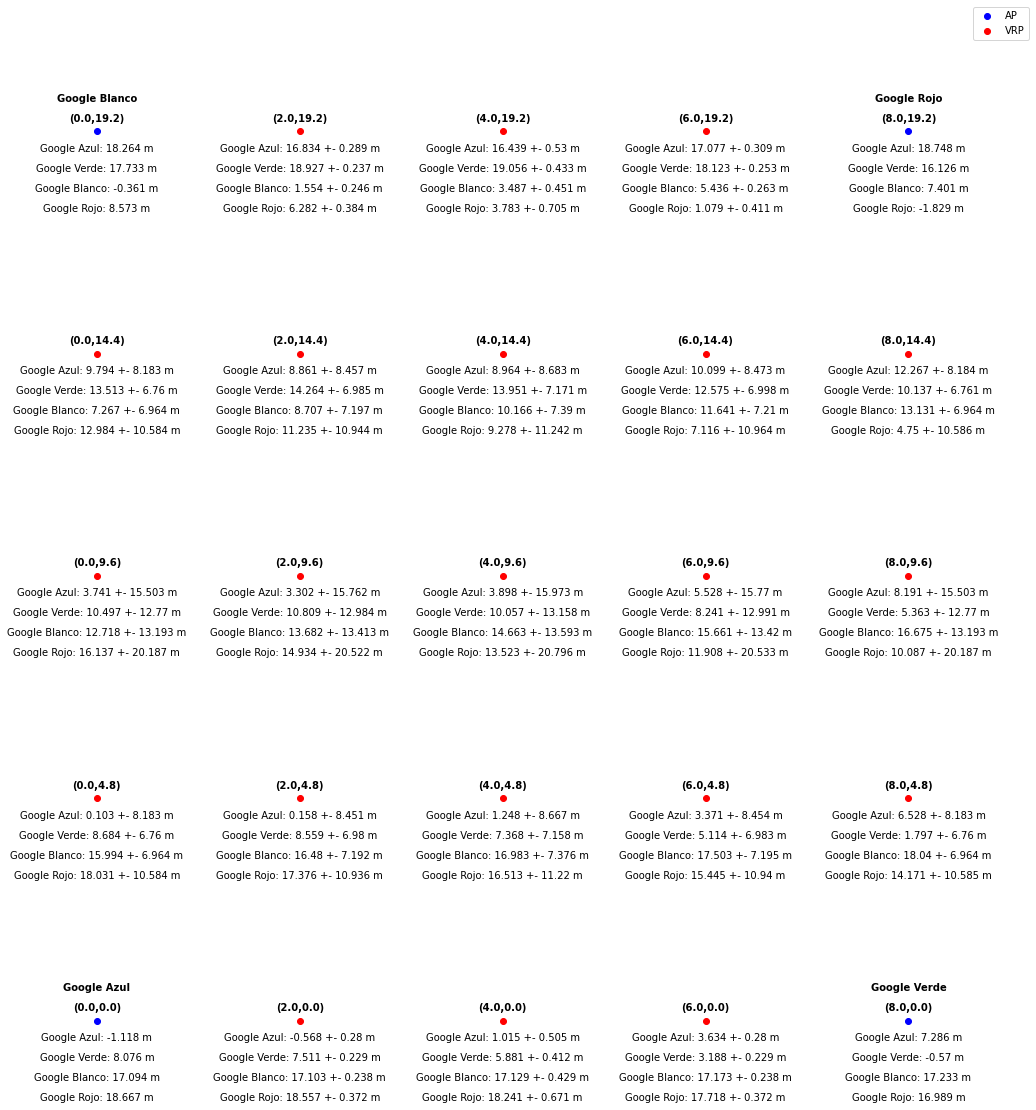

In [145]:
#@title ##Second Order PSFM GPR Fingerprinting Database plot

plt.figure(figsize=(16,18))

plt.scatter(coordinates_ap[:,0], coordinates_ap[:,1], c='b')
plt.scatter(coordinates_vrp[:,0], coordinates_vrp[:,1], c='r')

plt.legend(labels=['AP','VRP'],loc="upper right",borderaxespad=-8)
plt.axis('off')

for x in range(len(d_RTT[:,0])):
    for y in range(len(d_RTT[:,0])):
        label = f"{ap_labels[y]}: {d_RTT[x,y].round(3)} m"

        plt.annotate(label, # this is the text
                    (coordinates_ap[x,0],coordinates_ap[x,1]), # this is the point to label
                    textcoords="offset points", # how to position the text
                    xytext=(0,-20-y*20), # distance from text to points (x,y)
                    ha='center') # horizontal alignment can be left, right or center

for x in range(len(means_psfm2[0])):
    for y in range(len(d_RTT[:,0])):
        label = f"{ap_labels[y]}: {means_psfm2[:,x,:][y,0].round(3)} +- {variances[:,x,:][y,0].round(3)} m"

        plt.annotate(label, # this is the text
                    (coordinates_vrp[x,0],coordinates_vrp[x,1]), # this is the point to label
                    textcoords="offset points", # how to position the text
                    xytext=(0,-20-y*20), # distance from text to points (x,y)
                    ha='center') # horizontal alignment can be left, right or center

for x,y,z in zip(coordinates_ap[:,0],coordinates_ap[:,1], np.linspace(0, n_ap - 1, n_ap).astype(int)):

    label = f"{ap_labels[z]}"

    plt.annotate(label, # this is the text
                 (x,y), # this is the point to label
                 textcoords="offset points", # how to position the text
                 xytext=(0,30), # distance from text to points (x,y)
                 ha='center', # horizontal alignment can be left, right or center
                 weight='bold')

for x,y,z in zip(coordinates[:,0],coordinates[:,1], np.linspace(0, n_points - 1, n_points).astype(int)):
    label = f"({locations[z,0]},{locations[z,1]})"

    plt.annotate(label, # this is the text
                 (x,y), # this is the point to label
                 textcoords="offset points", # how to position the text
                 xytext=(0,10), # distance from text to points (x,y)
                 ha='center',
                 weight='bold') # horizontal alignment can be left, right or center

#Data validation

In [150]:
"""
Dataset Split VRP's
"""
vrp_meas = np.empty((n_vrp, n_ap, 100))

df.sort_values(ap_mac)
for count, row in enumerate(L_vrp):
  aux = df.loc[(df['y'] == row[0]) & (df['x'] == row[1]) & (df['model'] == 'Pixel 3a')]
  aux = aux[ap_mac].values
  aux = aux.T
  vrp_meas[count,:,:] = aux

In [151]:
#@title ##Google AP's Zero-Mean GPR Scoring

header = pd.MultiIndex.from_product([['Overall', 'Google Azul', 'Google Verde', 'Google Blanco', 'Google Rojo'],
                                     ['Mean Error','Max Error','Min Error']],
                                    names=['AP','Info'])

#score = pd.DataFrame(columns=['x','y','Mean Error','Max Error','Min error'])
score = pd.DataFrame(columns=header)

for i, row in enumerate(means[:,:,0].T.round(3)):
  vec_meas = row
  err = np.empty(0)

  for j, row in enumerate(vrp_meas[i].T):
    vec_test = row.round(3)
    diff = abs(vec_meas - vec_test)
    err = np.concatenate((err, diff))

  #Overall error
  res = np.array([np.nanmean(err).round(3), 
                  np.nanmax(err.round(3)), 
                  np.nanmin(err.round(3))])

  #Error by AP
  err = err.reshape((100,4))

  #Google Azul
  res = np.concatenate((res, np.array([np.nanmean(err[:,0]).round(3), 
                                      np.nanmax(err[:,0].round(3)), 
                                      np.nanmin(err[:,0].round(3))])))

  #Google Verde
  res = np.concatenate((res, np.array([np.nanmean(err[:,1]).round(3), 
                                      max(err[:,1].round(3)), 
                                      min(err[:,1].round(3))])))

  #Google Blanco
  res = np.concatenate((res, np.array([np.nanmean(err[:,2]).round(3), 
                                      np.nanmax(err[:,2].round(3)), 
                                      np.nanmin(err[:,2].round(3))])))

  #Google Rojo
  res = np.concatenate((res, np.array([np.nanmean(err[:,3]).round(3), 
                                      max(err[:,3].round(3)), 
                                      min(err[:,3].round(3))])))

  score = score.append(pd.DataFrame(data=[res], 
                                    columns=header, 
                                    index=[f"({L_vrp[i,0]}, {L_vrp[i,1]})"]))
  
score

ValueError: ignored

In [148]:
#@title ##Google AP's First Order PSFM GPR Scoring

header = pd.MultiIndex.from_product([['Overall', 'Google Azul', 'Google Verde', 'Google Blanco', 'Google Rojo'],
                                     ['Mean Error','Max Error','Min Error']],
                                    names=['AP','Info'])

#score = pd.DataFrame(columns=['x','y','Mean Error','Max Error','Min error'])
score = pd.DataFrame(columns=header)

for i, row in enumerate(means_psfm[:,:,0].T.round(3)):
  vec_meas = row
  err = np.empty(0)

  for j, row in enumerate(vrp_meas[i].T):
    vec_test = row.round(3)
    diff = abs(vec_meas - vec_test)
    err = np.concatenate((err, diff))

  #Overall error
  res = np.array([np.nanmean(err).round(3), 
                  np.nanmax(err.round(3)), 
                  np.nanmin(err.round(3))])

  #Error by AP
  err = err.reshape((78,4))

  #Google Azul
  res = np.concatenate((res, np.array([np.nanmean(err[:,0]).round(3), 
                                      np.nanmax(err[:,0].round(3)), 
                                      np.nanmin(err[:,0].round(3))])))

  #Google Verde
  res = np.concatenate((res, np.array([np.nanmean(err[:,1]).round(3), 
                                      max(err[:,1].round(3)), 
                                      min(err[:,1].round(3))])))

  #Google Blanco
  res = np.concatenate((res, np.array([np.nanmean(err[:,2]).round(3), 
                                      np.nanmax(err[:,2].round(3)), 
                                      np.nanmin(err[:,2].round(3))])))

  #Google Rojo
  res = np.concatenate((res, np.array([np.nanmean(err[:,3]).round(3), 
                                      max(err[:,3].round(3)), 
                                      min(err[:,3].round(3))])))

  score = score.append(pd.DataFrame(data=[res], 
                                    columns=header, 
                                    index=[f"({L_vrp[i,0]}, {L_vrp[i,1]})"]))
  
score

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:15: RuntimeWarning: overflow encountered in multiply
  from ipykernel import kernelapp as app
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:15: RuntimeWarning: invalid value encountered in multiply
  from ipykernel import kernelapp as app


AP                 Overall                 ...    Google Rojo               
Info            Mean Error      Max Error  ...      Max Error      Min Error
(2.0, 0.0)             inf            inf  ...  1.214916e+294   1.821300e+01
(4.0, 0.0)             inf            inf  ...  7.498740e+303   1.782900e+01
(6.0, 0.0)   2.021164e+301  3.144639e+303  ...  7.901412e+302   1.744500e+01
(0.0, 4.8)             inf            inf  ...  2.075368e+304   1.595700e+01
(2.0, 4.8)             inf            inf  ...            inf   1.507000e+01
(4.0, 4.8)             inf            inf  ...  8.346946e+293   1.420600e+01
(6.0, 4.8)             inf            inf  ...            inf   1.337400e+01
(8.0, 4.8)             inf            inf  ...            inf   1.248300e+01
(0.0, 9.6)             inf            inf  ...  1.230417e+303   1.361800e+01
(2.0, 9.6)             inf            inf  ...  7.012491e+294   1.211700e+01
(4.0, 9.6)             inf            inf  ...  5.319393e+304   1.060800e+01
(6.0, 9.6)             inf            inf  ...            inf   9.110000e+00
(8.0, 9.6)             inf            inf  ...            inf   7.605000e+00
(0.0, 14.4)            inf            inf  ...  1.923318e+296   1.128000e+01
(2.0, 14.4)            inf            inf  ...            inf   9.164000e+00
(4.0, 14.4)            inf            inf  ...            inf   7.007000e+00
(6.0, 14.4)            inf            inf  ...  7.012496e+294   4.847000e+00
(8.0, 14.4)            inf            inf  ...  2.583091e+274   2.727000e+00
(2.0, 19.2)            inf            inf  ...  1.638464e+305   5.964000e+00
(4.0, 19.2)            inf            inf  ...  4.232101e+280   3.400000e+00
(6.0, 19.2)  2.658362e+183  1.291722e+185  ...  1.291722e+185  2.139202e+179

[21 rows x 15 columns]

In [149]:
#@title ##Google AP's Second Order PSFM GPR Scoring

header = pd.MultiIndex.from_product([['Overall', 'Google Azul', 'Google Verde', 'Google Blanco', 'Google Rojo'],
                                     ['Mean Error','Max Error','Min Error']],
                                    names=['AP','Info'])

#score = pd.DataFrame(columns=['x','y','Mean Error','Max Error','Min error'])
score = pd.DataFrame(columns=header)

for i, row in enumerate(means_psfm2[:,:,0].T.round(3)):
  vec_meas = row
  err = np.empty(0)

  for j, row in enumerate(vrp_meas[i].T):
    vec_test = row.round(3)
    diff = abs(vec_meas - vec_test)
    err = np.concatenate((err, diff))

  #Overall error
  res = np.array([np.nanmean(err).round(3), 
                  np.nanmax(err.round(3)), 
                  np.nanmin(err.round(3))])

  #Error by AP
  err = err.reshape((78,4))

  #Google Azul
  res = np.concatenate((res, np.array([np.nanmean(err[:,0]).round(3), 
                                      np.nanmax(err[:,0].round(3)), 
                                      np.nanmin(err[:,0].round(3))])))

  #Google Verde
  res = np.concatenate((res, np.array([np.nanmean(err[:,1]).round(3), 
                                      max(err[:,1].round(3)), 
                                      min(err[:,1].round(3))])))

  #Google Blanco
  res = np.concatenate((res, np.array([np.nanmean(err[:,2]).round(3), 
                                      np.nanmax(err[:,2].round(3)), 
                                      np.nanmin(err[:,2].round(3))])))

  #Google Rojo
  res = np.concatenate((res, np.array([np.nanmean(err[:,3]).round(3), 
                                      max(err[:,3].round(3)), 
                                      min(err[:,3].round(3))])))

  score = score.append(pd.DataFrame(data=[res], 
                                    columns=header, 
                                    index=[f"({L_vrp[i,0]}, {L_vrp[i,1]})"]))
  
score

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:15: RuntimeWarning: overflow encountered in multiply
  from ipykernel import kernelapp as app
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:15: RuntimeWarning: invalid value encountered in multiply
  from ipykernel import kernelapp as app


AP                 Overall                 ...    Google Rojo               
Info            Mean Error      Max Error  ...      Max Error      Min Error
(2.0, 0.0)             inf            inf  ...  1.214916e+294   1.855700e+01
(4.0, 0.0)             inf            inf  ...  7.498740e+303   1.824100e+01
(6.0, 0.0)   2.021164e+301  3.144639e+303  ...  7.901412e+302   1.771800e+01
(0.0, 4.8)             inf            inf  ...  2.075368e+304   1.803100e+01
(2.0, 4.8)             inf            inf  ...            inf   1.737600e+01
(4.0, 4.8)             inf            inf  ...  8.346946e+293   1.649700e+01
(6.0, 4.8)             inf            inf  ...            inf   1.544500e+01
(8.0, 4.8)             inf            inf  ...            inf   1.417100e+01
(0.0, 9.6)             inf            inf  ...  1.230417e+303   1.613700e+01
(2.0, 9.6)             inf            inf  ...  7.012491e+294   1.493400e+01
(4.0, 9.6)             inf            inf  ...  5.319393e+304   1.351700e+01
(6.0, 9.6)             inf            inf  ...            inf   1.190800e+01
(8.0, 9.6)             inf            inf  ...            inf   1.008700e+01
(0.0, 14.4)            inf            inf  ...  1.923318e+296   1.298400e+01
(2.0, 14.4)            inf            inf  ...            inf   1.123500e+01
(4.0, 14.4)            inf            inf  ...            inf   9.278000e+00
(6.0, 14.4)            inf            inf  ...  7.012496e+294   7.116000e+00
(8.0, 14.4)            inf            inf  ...  2.583091e+274   4.750000e+00
(2.0, 19.2)            inf            inf  ...  1.638464e+305   6.224000e+00
(4.0, 19.2)            inf            inf  ...  4.232101e+280   3.783000e+00
(6.0, 19.2)  2.658362e+183  1.291722e+185  ...  1.291722e+185  2.139202e+179

[21 rows x 15 columns]

#Test section

In [ ]:
#@title ##First Order PSFM GPR Scoring with 8 APs
score = pd.DataFrame(columns=['x','y','Mean Error','Max Error','Min error'])
print(means_psfm.shape)
print(vrp_meas.shape)
for i, row in enumerate(means_psfm[:,:,0].T.round(3)):
  vec_meas = row
  err = np.empty(0)
  for j, row in enumerate(vrp_meas[i].T):
    vec_test = row.round(3)
    diff = abs(vec_meas - vec_test)
    diff = np.delete(diff, 3)
    diff = np.delete(diff, 4)
    err = np.concatenate((err, diff))
  
  res = pd.DataFrame({'x':L_vrp[i,0],
                        'y':L_vrp[i,1],
                        'Mean Error': [np.nanmean(err).round(3)], 
                        'Max Error': [max(err.round(3))], 
                        'Min error': [min(err.round(3))]})
  score = score.append(res)

score.set_index(['x','y'])

(4, 21, 1)
(21, 4, 78)


IndexError: ignored

In [ ]:
#@title ##Zero-Mean GPR Google Azul Scoring
score = pd.DataFrame(columns=['x','y','Mean Error','Max Error','Min error'])

for i, row in enumerate(means[:,:,0].T.round(3)):
  vec_meas = row
  err = np.empty(78)
  for j, row in enumerate(vrp_meas[i].T):
    vec_test = row.round(3)
    diff = abs(vec_meas[0] - vec_test[0])
    err[j] = diff
  res = pd.DataFrame({'x':L_vrp[i,0],
                        'y':L_vrp[i,1],
                        'Mean Error': [np.nanmean(err).round(3)], 
                        'Max Error': [max(err.round(3))], 
                        'Min error': [min(err.round(3))]})
  score = score.append(res)

score.set_index(['x','y'])

In [ ]:
#@title ##Google AP's Zero-Mean GPR Scoring with 8 APs

header = pd.MultiIndex.from_product([['Overall','Google Azul','Google Verde', 
                                      'Google Blanco','Google Rojo'],
                                     ['Mean Error','Max Error','Min Error']],
                                    names=['AP','Info'])

#score = pd.DataFrame(columns=['x','y','Mean Error','Max Error','Min error'])
score = pd.DataFrame(columns=header)

for i, row in enumerate(means[:,:,0].T.round(3)):
  vec_meas = row
  err = np.empty(0)

  for j, row in enumerate(vrp_meas[i].T):
    vec_test = row.round(3)
    diff = abs(vec_meas - vec_test)
    diff = np.delete(diff, [1,3,4,6])
    err = np.concatenate((err, diff))

  #Overall error
  res = np.array([np.nanmean(err).round(3), 
                  np.nanmax(err.round(3)), 
                  np.nanmin(err.round(3))])

  #Error by AP
  err = err.reshape((78,4))

  #Google Azul
  res = np.concatenate((res, np.array([np.nanmean(err[:,0]).round(3), 
                                      np.nanmax(err[:,0].round(3)), 
                                      np.nanmin(err[:,0].round(3))])))

  #Google Verde
  res = np.concatenate((res, np.array([np.nanmean(err[:,1]).round(3), 
                                      max(err[:,1].round(3)), 
                                      min(err[:,1].round(3))])))

  #Google Blanco
  res = np.concatenate((res, np.array([np.nanmean(err[:,2]).round(3), 
                                      np.nanmax(err[:,2].round(3)), 
                                      np.nanmin(err[:,2].round(3))])))

  #Google Rojo
  res = np.concatenate((res, np.array([np.nanmean(err[:,3]).round(3), 
                                      max(err[:,3].round(3)), 
                                      min(err[:,3].round(3))])))

  score = score.append(pd.DataFrame(data=[res], 
                                    columns=header, 
                                    index=[f"({L_vrp[i,0]}, {L_vrp[i,1]})"]))
  
score

IndexError: ignored